In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Loading all datasets
happiness = pd.read_csv("Happiness.csv")
gdp = pd.read_excel("GDP.xls")
edu = pd.read_excel("Education.xls")

In [3]:
#Adding Column "Year" for year Restriction
happiness = happiness.rename(columns={"Score": "happiness_score", "Country or region": "country"})
happiness["year"] = 2019
happiness_renamed = happiness.copy()

In [4]:
print("Happiness columns:", happiness.columns)
print("GDP columns:", gdp.columns)
print("Education columns:", edu.columns)

Happiness columns: Index(['Overall rank', 'country', 'happiness_score', 'GDP per capita',
       'Social support', 'Healthy life expectancy',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'year'],
      dtype='object')
GDP columns: Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968',
       '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977',
       '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986',
       '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
       '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022',
       '2023', '2024'],
      dtype='object')
Education columns: Index(['Country Name', 'Country 

In [5]:
gdp_year_cols = [col for col in gdp.columns if col.isdigit()]
edu_year_cols = [col for col in edu.columns if col.isdigit()]

In [6]:
gdp_long = gdp.melt(
    id_vars=["Country Name"],
    value_vars=gdp_year_cols,
    var_name="year",
    value_name="gdp_per_capita"
)
gdp_long = gdp_long.rename(columns={"Country Name": "country"})
gdp_long["year"] = gdp_long["year"].astype(int)

In [7]:
edu_long = edu.melt(
    id_vars=["Country Name"],
    value_vars=edu_year_cols,
    var_name="year",
    value_name="edu_expenditure"
)
edu_long = edu_long.rename(columns={"Country Name": "country"})
edu_long["year"] = edu_long["year"].astype(int)

In [8]:
gdp_2019 = gdp_long[gdp_long["year"] == 2019]
edu_2019 = edu_long[edu_long["year"] == 2019]

In [9]:
print("Happiness columns:", happiness.columns.tolist())
print("GDP columns:", gdp_2019.columns.tolist())
print("Education columns:", edu_2019.columns.tolist())

Happiness columns: ['Overall rank', 'country', 'happiness_score', 'GDP per capita', 'Social support', 'Healthy life expectancy', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'year']
GDP columns: ['country', 'year', 'gdp_per_capita']
Education columns: ['country', 'year', 'edu_expenditure']


In [10]:
merged_two = pd.merge(happiness_renamed, gdp_2019, on=["country", "year"], how="left")
df = pd.merge(merged_two, edu_2019, on=["country", "year"], how="left")
print("Merged shape:", df.shape)
df

Merged shape: (156, 12)


,Overall rank,country,happiness_score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393,2019,48358.180777,6.453000
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410,2019,59404.266325,7.275880
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341,2019,76430.588947,7.864560
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118,2019,68452.236223,7.601300
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298,2019,53554.900749,5.055940
...,...,...,...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.359,0.711,0.614,0.555,0.217,0.411,2019,810.051412,3.238212
152,153,Tanzania,3.231,0.476,0.885,0.499,0.417,0.276,0.147,2019,1063.322510,3.596836
153,154,Afghanistan,3.203,0.350,0.517,0.361,0.000,0.158,0.025,2019,496.602504,NaN
154,155,Central African Republic,3.083,0.026,0.000,0.105,0.225,0.235,0.035,2019,449.228468,1.767921


In [11]:
df["gdp_per_capita"] = df["gdp_per_capita"].fillna(df["gdp_per_capita"].median())

df["edu_expenditure"] = df["edu_expenditure"].fillna(df["edu_expenditure"].mean())

df["happiness_score"] = df["happiness_score"].fillna(df["happiness_score"].mean())
df['year'] = df['year'].astype(int)
df_fin=df.drop(columns=['GDP per capita']) #Deleting GDP per capita from Happiness dataset
df_fin


,Overall rank,country,happiness_score,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
0,1,Finland,7.769,1.587,0.986,0.596,0.153,0.393,2019,48358.180777,6.453000
1,2,Denmark,7.600,1.573,0.996,0.592,0.252,0.410,2019,59404.266325,7.275880
2,3,Norway,7.554,1.582,1.028,0.603,0.271,0.341,2019,76430.588947,7.864560
3,4,Iceland,7.494,1.624,1.026,0.591,0.354,0.118,2019,68452.236223,7.601300
4,5,Netherlands,7.488,1.522,0.999,0.557,0.322,0.298,2019,53554.900749,5.055940
...,...,...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.711,0.614,0.555,0.217,0.411,2019,810.051412,3.238212
152,153,Tanzania,3.231,0.885,0.499,0.417,0.276,0.147,2019,1063.322510,3.596836
153,154,Afghanistan,3.203,0.517,0.361,0.000,0.158,0.025,2019,496.602504,4.302629
154,155,Central African Republic,3.083,0.000,0.105,0.225,0.235,0.035,2019,449.228468,1.767921


In [12]:
df_fin.describe()

,Overall rank,happiness_score,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.0,156.000000,156.000000
mean,78.500000,5.407096,1.208814,0.725244,0.392571,0.184846,0.110603,2019.0,14844.211796,4.302629
std,45.177428,1.113120,0.299191,0.242124,0.143289,0.095254,0.094538,0.0,20438.896883,1.408102
min,1.000000,2.853000,0.000000,0.000000,0.000000,0.000000,0.000000,2019.0,210.236495,0.358479
25%,39.750000,4.544500,1.055750,0.547750,0.308000,0.108750,0.047000,2019.0,2443.034385,3.553942
50%,78.500000,5.379500,1.271500,0.789000,0.417000,0.177500,0.085500,2019.0,6472.545449,4.302629
75%,117.250000,6.184500,1.452500,0.881750,0.507250,0.248250,0.141250,2019.0,16025.368197,4.962975
max,156.000000,7.769000,1.624000,1.141000,0.631000,0.566000,0.453000,2019.0,112696.649060,9.322532


                              Overall rank  happiness_score  Social support  \
Overall rank                      1.000000        -0.989096       -0.767465   
happiness_score                  -0.989096         1.000000        0.777058   
Social support                   -0.767465         0.777058        1.000000   
Healthy life expectancy          -0.787411         0.779883        0.719009   
Freedom to make life choices     -0.546606         0.566742        0.447333   
Generosity                       -0.047993         0.075824       -0.048126   
Perceptions of corruption        -0.351959         0.385613        0.181899   
year                                   NaN              NaN             NaN   
gdp_per_capita                   -0.685329         0.706701        0.509677   
edu_expenditure                  -0.298744         0.314900        0.321610   

                              Healthy life expectancy  \
Overall rank                                -0.787411   
happiness_score 

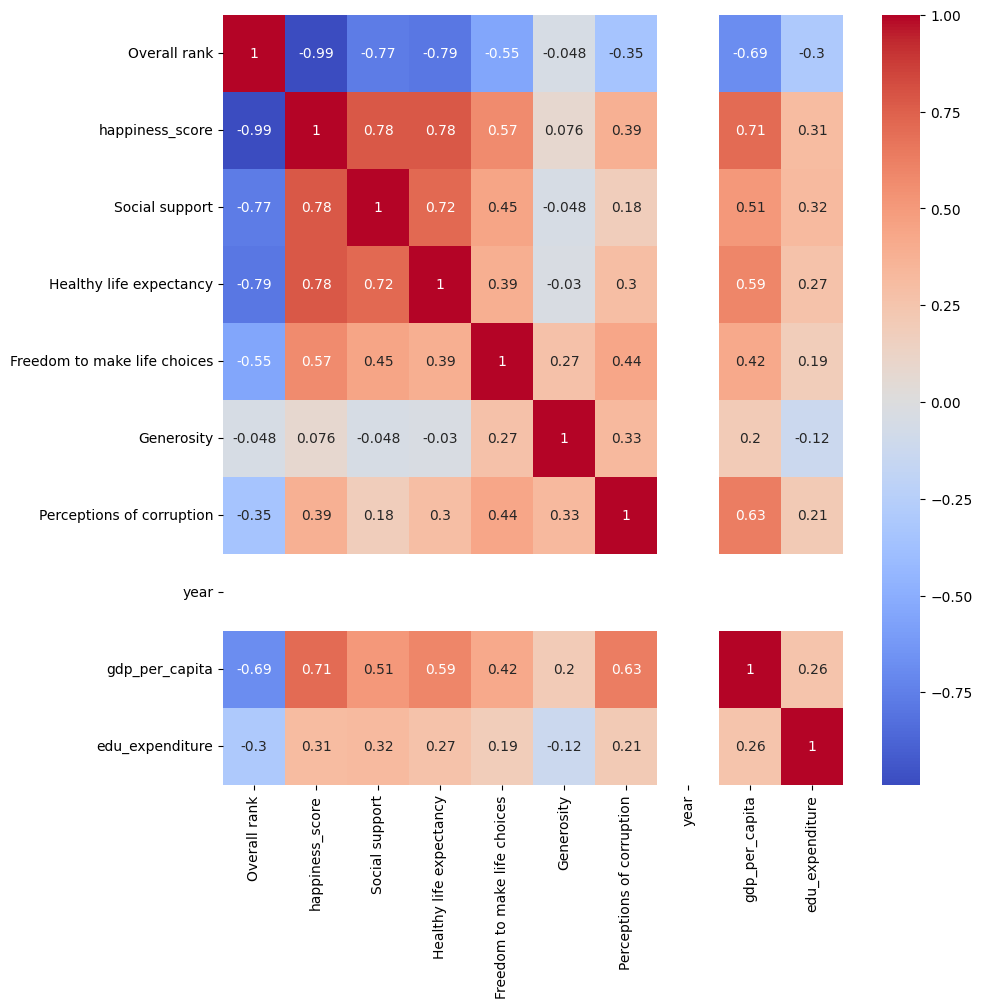

In [13]:
corr_hap=df_fin.select_dtypes(include=['number']).corr()
print(corr_hap)
plt.figure(figsize=(10,10))
sns.heatmap(corr_hap, annot=True, cmap='coolwarm')
plt.show()

#Positive and closer to 1 shows best correlation
#Negative and far from 1 shows worst correlation

In [14]:
sorted_happy=df_fin.sort_values(by="happiness_score", ascending=False)
sorted_happy

,Overall rank,country,happiness_score,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
0,1,Finland,7.769,1.587,0.986,0.596,0.153,0.393,2019,48358.180777,6.453000
1,2,Denmark,7.600,1.573,0.996,0.592,0.252,0.410,2019,59404.266325,7.275880
2,3,Norway,7.554,1.582,1.028,0.603,0.271,0.341,2019,76430.588947,7.864560
3,4,Iceland,7.494,1.624,1.026,0.591,0.354,0.118,2019,68452.236223,7.601300
4,5,Netherlands,7.488,1.522,0.999,0.557,0.322,0.298,2019,53554.900749,5.055940
...,...,...,...,...,...,...,...,...,...,...,...
151,152,Rwanda,3.334,0.711,0.614,0.555,0.217,0.411,2019,810.051412,3.238212
152,153,Tanzania,3.231,0.885,0.499,0.417,0.276,0.147,2019,1063.322510,3.596836
153,154,Afghanistan,3.203,0.517,0.361,0.000,0.158,0.025,2019,496.602504,4.302629
154,155,Central African Republic,3.083,0.000,0.105,0.225,0.235,0.035,2019,449.228468,1.767921


In [15]:
top_10=sorted_happy.head(10)
top_10

,Overall rank,country,happiness_score,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
0,1,Finland,7.769,1.587,0.986,0.596,0.153,0.393,2019,48358.180777,6.45300
1,2,Denmark,7.600,1.573,0.996,0.592,0.252,0.410,2019,59404.266325,7.27588
2,3,Norway,7.554,1.582,1.028,0.603,0.271,0.341,2019,76430.588947,7.86456
3,4,Iceland,7.494,1.624,1.026,0.591,0.354,0.118,2019,68452.236223,7.60130
4,5,Netherlands,7.488,1.522,0.999,0.557,0.322,0.298,2019,53554.900749,5.05594
5,6,Switzerland,7.480,1.526,1.052,0.572,0.263,0.343,2019,84121.931030,5.01439
6,7,Sweden,7.343,1.487,1.009,0.574,0.267,0.373,2019,51773.046456,7.66306
7,8,New Zealand,7.307,1.557,1.026,0.585,0.330,0.380,2019,42779.229816,5.17798
8,9,Canada,7.278,1.505,1.039,0.584,0.285,0.308,2019,46352.869345,4.77293
9,10,Austria,7.246,1.475,1.016,0.532,0.244,0.226,2019,49885.994736,5.23678


In [16]:
down_10=sorted_happy.tail(10)
down_10

,Overall rank,country,happiness_score,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,year,gdp_per_capita,edu_expenditure
146,147,Haiti,3.597,0.688,0.449,0.026,0.419,0.110,2019,1352.172042,1.084150
147,148,Botswana,3.488,1.145,0.538,0.455,0.025,0.100,2019,7172.089565,8.398997
148,149,Syria,3.462,0.378,0.440,0.013,0.331,0.141,2019,6472.545449,4.302629
149,150,Malawi,3.410,0.560,0.495,0.443,0.218,0.089,2019,580.889816,4.302629
150,151,Yemen,3.380,1.163,0.463,0.143,0.108,0.077,2019,6472.545449,4.302629
151,152,Rwanda,3.334,0.711,0.614,0.555,0.217,0.411,2019,810.051412,3.238212
152,153,Tanzania,3.231,0.885,0.499,0.417,0.276,0.147,2019,1063.322510,3.596836
153,154,Afghanistan,3.203,0.517,0.361,0.000,0.158,0.025,2019,496.602504,4.302629
154,155,Central African Republic,3.083,0.000,0.105,0.225,0.235,0.035,2019,449.228468,1.767921
155,156,South Sudan,2.853,0.575,0.295,0.010,0.202,0.091,2019,6472.545449,4.302629


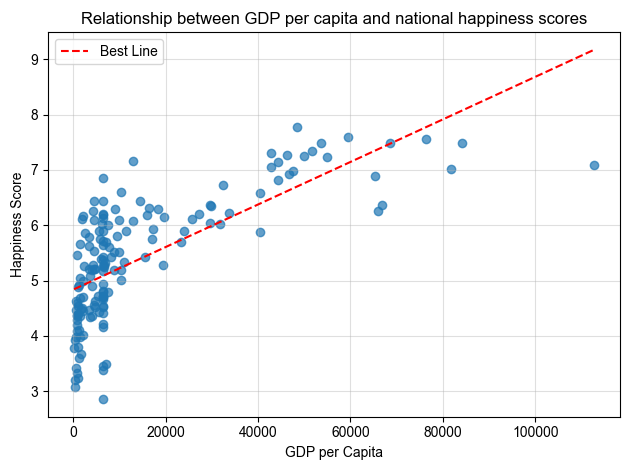

In [17]:
plt.scatter(df_fin['gdp_per_capita'], df_fin["happiness_score"], alpha=0.7)

slp,inr=np.polyfit(df_fin['gdp_per_capita'], df_fin["happiness_score"],1)
x_line=np.array([df_fin['gdp_per_capita'].min(), df_fin["gdp_per_capita"].max()])
y_line=slp*x_line+inr 
plt.plot(x_line, y_line, c="red", lw=1.5, ls="dashed", label="Best Line")

plt.title('Relationship between GDP per capita and national happiness scores')
plt.xlabel("GDP per Capita")
plt.ylabel("Happiness Score")
plt.legend()

plt.grid(True, alpha=0.4)
plt.tight_layout()
sns.set_theme()
plt.show()

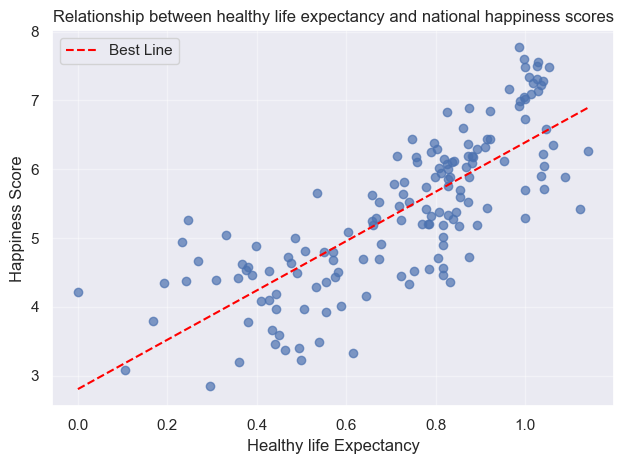

In [18]:
plt.scatter(df_fin['Healthy life expectancy'], df_fin["happiness_score"], alpha=0.7)

slp,inr=np.polyfit(df_fin['Healthy life expectancy'], df_fin["happiness_score"],1)
x_line=np.array([df_fin['Healthy life expectancy'].min(), df_fin["Healthy life expectancy"].max()])
y_line=slp*x_line+inr 
plt.plot(x_line, y_line, c="red", lw=1.5, ls="dashed", label="Best Line")

plt.title('Relationship between healthy life expectancy and national happiness scores')
plt.xlabel("Healthy life Expectancy")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
sns.set_theme()
plt.show()


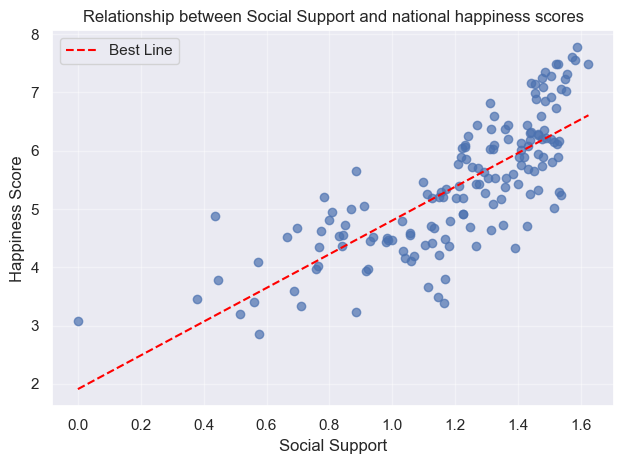

In [19]:
plt.scatter(df_fin['Social support'], df_fin["happiness_score"], alpha=0.7)

slp,inr=np.polyfit(df_fin['Social support'], df_fin["happiness_score"],1)
x_line=np.array([df_fin['Social support'].min(), df_fin["Social support"].max()])
y_line=slp*x_line+inr 
plt.plot(x_line, y_line, c="red", lw=1.5, ls="dashed", label="Best Line")

plt.title('Relationship between Social Support and national happiness scores')
plt.xlabel("Social Support")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
sns.set_theme()
plt.show()


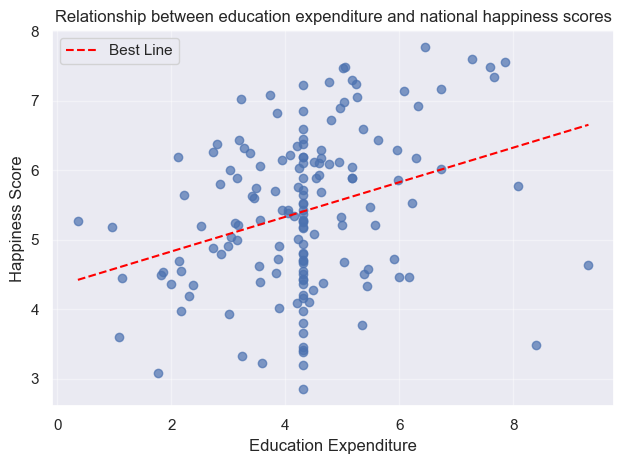

In [20]:
plt.scatter(df_fin['edu_expenditure'], df_fin["happiness_score"], alpha=0.7)

slp,inr=np.polyfit(df_fin["edu_expenditure"], df_fin["happiness_score"],1)
x_line=np.array([df_fin['edu_expenditure'].min(), df_fin["edu_expenditure"].max()])
y_line=slp*x_line+inr 
plt.plot(x_line, y_line, c="red", lw=1.5, ls="dashed", label="Best Line")

plt.title('Relationship between education expenditure and national happiness scores')
plt.xlabel("Education Expenditure")
plt.ylabel("Happiness Score")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
sns.set_theme()
plt.show()

In [25]:
import plotly.express as px

df_map = happiness[["country", "happiness_score"]].copy()
fig = px.choropleth(df_map, 
                    locations='country', 
                    color='happiness_score',
                    locationmode='country names', 
                    color_continuous_scale=px.colors.sequential.speed_r,
                    title='Global Happiness Score (2019)',
                    height=560
                   )
fig.update_xaxes(automargin=True)
fig.update_yaxes(automargin=True)
fig.show()

/var/folders/ff/vp6bqjwx02x1bqcbnd6kl6lw0000gn/T/ipykernel_23418/3237593572.py:4: DeprecationWarning:

The library used by the *country names* `locationmode` option is changing in an upcoming version. Country names in existing plots may not work in the new version. To ensure consistent behavior, consider setting `locationmode` to *ISO-3*.



In [22]:
df_fin.to_csv("FinalDataFrame.csv")